### NOTES

##### * In this project, a consistent approach involves using the apply() method with a nested lambda function. The apply() method applies a function to the values in one or more fields of a Pandas DataFrame. Nested lambda functions allow efficient iteration over field values, incorporating if-else logic seamlessly. This approach avoids repetitive loops and enables concise, expressive data manipulation. These notes serve to document the approach, reducing the need to repeat explanations in subsequent code descriptions.

#### Importing relevant libraries needed

In [145]:
# import libraries 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime

## Missing Data

#### Importing the missing data CSV and Warehouse data CSV used that will be needed for data imputation

In [146]:
# import files
missing_data = pd.read_csv('35087056_missing_data.csv')
warehouses = pd.read_csv('warehouses.csv')

#### Use the .info() method on both csv files to inspect the metadata of the missing data csv and warehouse csv. This allows for identification of where the missing rows are, allows for inspection of the datatype of each column which is important when performing imputation as well as ensures the data has been imported as expected.

In [147]:
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              445 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    485 non-null    float64
 6   delivery_charges               460 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    485 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

In [148]:
warehouses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   names   3 non-null      object 
 1   lat     3 non-null      float64
 2   lon     3 non-null      float64
dtypes: float64(2), object(1)
memory usage: 204.0+ bytes


### Missing Data - Exploratory Data Analysis (EDA)

#### Conduct a dataframe using the chained method of isna().sum() of all columns which contain at least one or more missing rows in the data set. This provides an overview what columns will need to be imputed as well as the frequency of the missing rows in each. 

In [149]:
# Find fields containing 
missing_data_eda = missing_data.isna().sum()[missing_data.isna().sum() > 0].to_frame()

# Reset Index, Rename columns and display table
missing_data_eda = missing_data_eda.reset_index()
missing_data_eda = missing_data_eda.rename(columns={'index':'Column',0:'Missing Row Count'})
missing_data_eda


,Column,Missing Row Count
0,nearest_warehouse,55
1,order_price,15
2,delivery_charges,40
3,order_total,15
4,distance_to_nearest_warehouse,31
5,is_happy_customer,40


#### Construct a Bar Graph visualisation of the above data frame, a seperate graph for each column containing missing values with individual missing row counts for each bar/column. The approach taken here was to create six different different varaibles for each column containing the row counts.

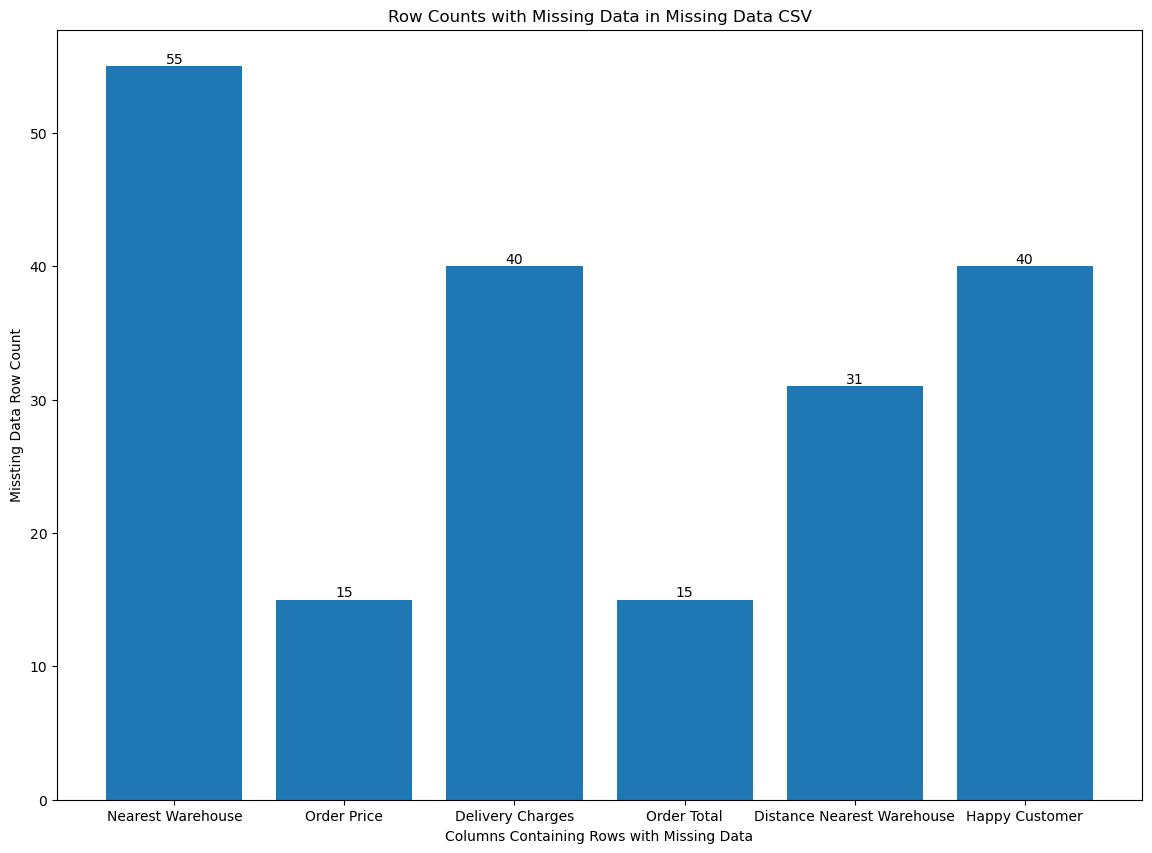

In [150]:
# Visualise

nearest_warehouse_missing = missing_data['nearest_warehouse'].isna().sum()
order_price_missing = missing_data['order_price'].isna().sum()
delivery_charges_missing = missing_data['delivery_charges'].isna().sum()
order_total_missing = missing_data['order_total'].isna().sum()
distance_warehouse_missing = missing_data['distance_to_nearest_warehouse'].isna().sum()
is_happy_customer_missing = missing_data['is_happy_customer'].isna().sum()

missing_data_counts = [nearest_warehouse_missing,order_price_missing,delivery_charges_missing,
                       order_total_missing,distance_warehouse_missing,is_happy_customer_missing]

variables = ['Nearest Warehouse', 'Order Price', 'Delivery Charges', 
             'Order Total', 'Distance Nearest Warehouse','Happy Customer']

fig, ax = plt.subplots(figsize=(14, 10))
bars = plt.bar(variables, missing_data_counts)

for bar in bars:
    height = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Columns Containing Rows with Missing Data')
plt.ylabel('Missting Data Row Count')
plt.title('Row Counts with Missing Data in Missing Data CSV')
plt.show()

#### Define a function to calculate the distance between two points on a sphere (The Haversine Formula), this will calculate the distance in kilometers between two sets of longitude and lattitude inputs to find the nearest warehouse for a set of corrdinates as well as the distance to the nearest warehouse.

In [151]:
# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    alpha = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    distance = R * 2 * np.arctan2(np.sqrt(alpha), np.sqrt(1 - alpha))
    return distance

#### Where the nearest warehouse field is null, conduct a look up on the warehouse csv and determine the closest warehouse using the haversine formmu;a

In [152]:
# Nearest Warehouse 
missing_data['nearest_warehouse'] = missing_data.apply(
    lambda row: warehouses.loc[
        warehouses.apply(
            lambda x: haversine(row['customer_lat'], row['customer_long'], x['lat'], x['lon']),
            axis=1
        ).idxmin()]['names'] if pd.isnull(row['nearest_warehouse']) else row['nearest_warehouse'],
    axis=1
)

#### Merge the missing data csv and the warehouse dataframe to join the warehouse column fields using the warehouse names as the join key. if the distance to warehouse field is null, apply the haversine forumla and impute the values using both sets of longitute and lattitude inputs as the haversine function requires.

In [153]:
# Distance to Nearest Warehouse
merged_df = pd.merge(missing_data, warehouses, how='left', left_on='nearest_warehouse', right_on='names')

merged_df['distance_to_nearest_warehouse'] = merged_df.apply(
    lambda row: round(haversine(row['customer_lat'], row['customer_long'], row['lat'], row['lon']), 4)
    if pd.isnull(row['distance_to_nearest_warehouse']) else row['distance_to_nearest_warehouse'], 
    axis=1
)

missing_data = merged_df.drop(columns=['names','lat','lon'])

#### Use K-NearestNighbours (KNN) to Impute values for the order price field where the values are currently missing, this model was chosen as it essentially looks at similiar data points based on features provided to estimate a value. 
#### General Steps:
#### 1. Define the relevant features to use for the KNN model 
#### 2. Convert the Shopping Cart Items field into a list of countable values
#### 3. Define the field to be imputed (order price)
#### 4. Isolate rows to be imputed
#### 5. Impute for all values that are currently missing


In [154]:
# Order Price
from sklearn.impute import KNNImputer

# Select relevant columns for imputation
columns_to_use = ['shopping_cart', 'order_price', 'delivery_charges',
                  'coupon_discount', 'distance_to_nearest_warehouse', 'order_total']

data_subset = missing_data[columns_to_use].copy()

# Get count of itmes containing within shopping card for each row
data_subset['shopping_cart_items'] = data_subset['shopping_cart'].apply(
    lambda x: sum(int(item.split(",")[1].strip().strip(')')) for item in x.strip('[]').split('), (')) if isinstance(x, str) else 0
)

# Drop the original shopping_cart column and rearrange
data_subset = data_subset.drop(columns=['shopping_cart'])

# Separate fields to impute (order_total)
fields_to_impute = 'order_price'

# Convert to numeric and check for nulls
data_subset[fields_to_impute] = pd.to_numeric(data_subset[fields_to_impute], errors='coerce')

# Use KNN Imputer
imputer = KNNImputer(n_neighbors=1)
imputed_data = imputer.fit_transform(data_subset)

# Convert the result back to a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=data_subset.columns)

# Restore the imputed 'order_total' to the original DataFrame
missing_data['order_price'] = imputed_df['order_price']

#### Apply the simple calculation for each row where order total is missing to workout the order total. order price multiplied by the coupon percentage discount with the addition of the delivery charge

In [155]:
# Order Total
missing_data['order_total'] = missing_data.apply(
    lambda row: row['order_price'] * (1 - (row['coupon_discount']/100)) + row['delivery_charges'] if pd.isna(row['order_total']) else row['order_total'],
    axis=1)

#### Apply simple calculation for each row where the delivery charge row is missing, order total minus the order price multiplied by the coupon percentage discount

In [156]:
# Delivery Charges
missing_data['delivery_charges'] = missing_data.apply(
    lambda row: row['order_total'] - (row['order_price'] * (1 - (row['coupon_discount']/100))) if pd.isna(row['delivery_charges']) else row['delivery_charges'],
    axis=1)

#### Apply the NLTK Vader sentiment analyser to impute the binary score, 1 being positive and 0 being negative over the is happy customer field where it is missing.

In [157]:
# Happy Customer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

missing_data['is_happy_customer'] = missing_data.apply(
    lambda row: 1 if pd.isnull(row['is_happy_customer']) and vader.polarity_scores(row['latest_customer_review'])['compound'] > 0 
    else (0 if pd.isnull(row['is_happy_customer']) else row['is_happy_customer']),
    axis=1
)

#### Check all fields contain no further missing rows

In [158]:
# Check for missing rows
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    float64
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

#### Extract clean missing data csv to completeion solution csv

In [159]:
# Write missing data solution to csv
missing_data.to_csv('35087056_missing_data_solution.csv')

## Dirty Data

#### Importing the dirty data CSV 

In [160]:
dirty_data = pd.read_csv('35087056_dirty_data.csv')

#### Use .info() method to check meta data to ensure data was imported correctly

In [161]:
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

### Dirty Data - Exploratory Data Analysis (EDA)

#### Construct a data frame by passing in summed counts of the five columns containing dirty and unstandardides data. Create a dictionary of filed to variable mappings an display the dataframe.

In [162]:
# Dirty Data - EDA

dirty_data['customer_lat'] = dirty_data['customer_lat'].astype(str)
dirty_data['customer_long'] = dirty_data['customer_long'].astype(str)

dirty_date_count = dirty_data['date'].str.contains('-').sum()
warehouse_names = dirty_data['nearest_warehouse'].str.islower().sum()
lat_decimals = dirty_data['customer_lat'].apply(lambda x: 1 if isinstance(x, str) and "." in x and len(x.split(".")[1]) != 7 else 0).sum()
lon_decimals = dirty_data['customer_long'].apply(lambda x: 1 if isinstance(x, str) and "." in x and len(x.split(".")[1]) != 7 else 0).sum()
affected_review_count = sum(dirty_data['latest_customer_review'].apply(lambda x: ''.join([char for char in str(x) 
                                                                                          if (32 <= ord(char) <= 126 or char == '!')])) != dirty_data['latest_customer_review'])

dirty_data_eda = {'Incorrect_Date':dirty_date_count,
                 'Incorrect_Warehouse_Names':warehouse_names,
                 'Adjust_Lat_Decimals':lat_decimals,
                 'Adjust_Lon_Decimals':lon_decimals,
                 'Non_ASCII_Rows_Review':affected_review_count}

# Reset Index, Rename columns and display table
dirty_data_eda = pd.DataFrame.from_dict(dirty_data_eda,orient='index')
dirty_data_eda = dirty_data_eda.reset_index()
dirty_data_eda = dirty_data_eda.rename(columns={'index':'Column',0:'Error Row Count'})
dirty_data_eda

,Column,Error Row Count
0,Incorrect_Date,14
1,Incorrect_Warehouse_Names,22
2,Adjust_Lat_Decimals,60
3,Adjust_Lon_Decimals,52
4,Non_ASCII_Rows_Review,28


#### Construct a Bar Graph visualisation of the above data frame, a seperate graph for each column containing dirty data with individual dirty row row counts for each bar/column. The approach taken here was to create five different different varaibles for each column containing the row counts.

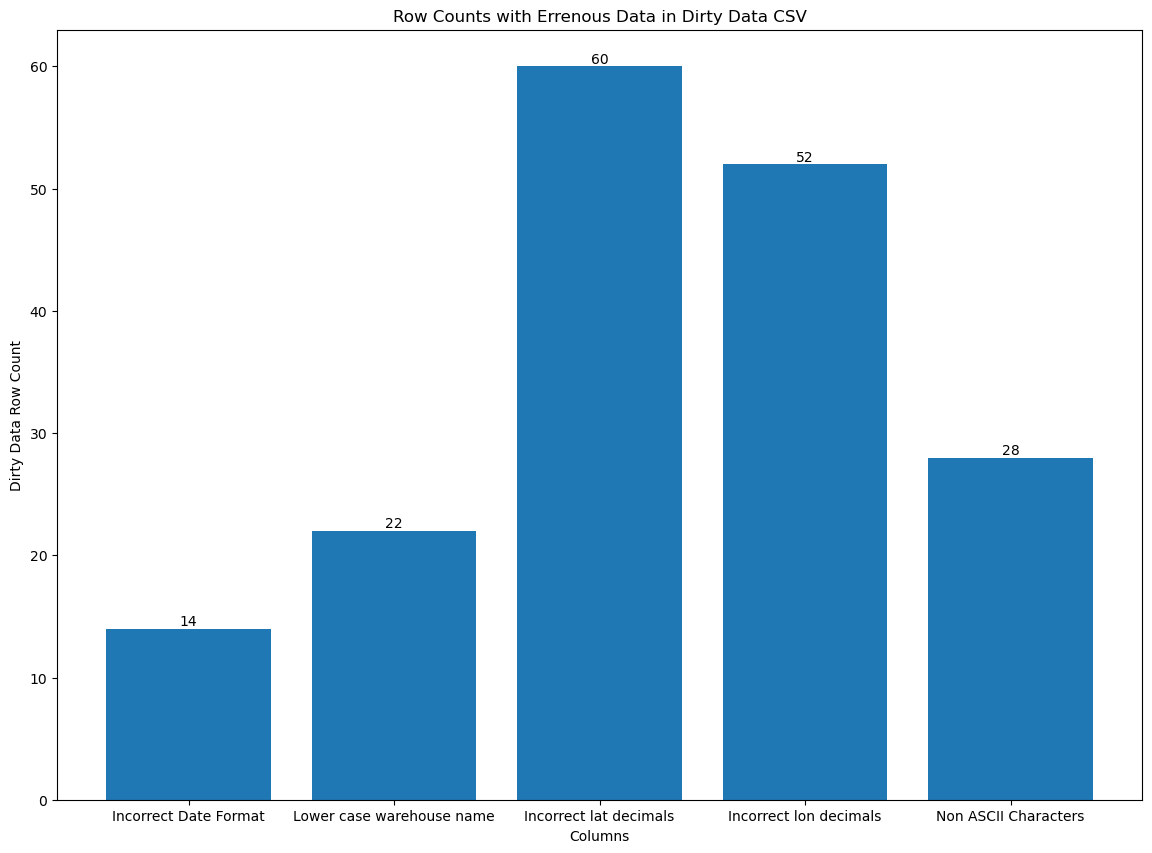

In [163]:
# Dirty Data - Visual EDA

dirty_data_counts = [dirty_date_count,warehouse_names,lat_decimals,lon_decimals,affected_review_count]
variables = ['Incorrect Date Format', 'Lower case warehouse name', 'Incorrect lat decimals', 'Incorrect lon decimals', 'Non ASCII Characters']

fig, ax = plt.subplots(figsize=(14, 10))
bars = plt.bar(variables, dirty_data_counts)

for bar in bars:
    height = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Columns')
plt.ylabel('Dirty Data Row Count')
plt.title('Row Counts with Errenous Data in Dirty Data CSV')
plt.show()

#### Adjust dates to use the / delimiter instead of the - delimiter to seperate year, month and day

In [ ]:
# Date
dirty_data['date'] = missing_data.apply(
    lambda row: datetime.strptime(row['date'], '%Y-%m-%d') if '-' in str(row['date']) else row['date'],
    axis=1
)

#### Adjust warehouse names to use title case if they are all in lower case

In [165]:
# Nearest Warehouse Names Title case
dirty_data['nearest_warehouse'] = missing_data.apply(
    lambda row: row['nearest_warehouse'].title() if row['nearest_warehouse'].islower() else row['nearest_warehouse'],
    axis=1
)

#### Convert the lattitude and longitude values to floats the nround the values to 7 decimal points to standardise those values

In [166]:
# Customer_lat and Customer_long adjustment
dirty_data['customer_lat'] = dirty_data['customer_lat'].astype(float)
dirty_data['customer_long'] = dirty_data['customer_long'].astype(float)

dirty_data['customer_lat'] = dirty_data['customer_lat'].apply(lambda x: round(x, 7))
dirty_data['customer_long'] = dirty_data['customer_long'].apply(lambda x: round(x, 7))

#### Standardise the distance to nearest warehouse field to 4 decimal places

In [167]:
# Distance to Nearest Warehouse
dirty_data['distance_to_nearest_warehouse'] = dirty_data['distance_to_nearest_warehouse'].apply(lambda x: round(x, 4))

#### Remove all none ASCII characters from the latest customer review field except for the exclamation mark to remove characters that prevent comment readability.

In [168]:
# Customer reviews
dirty_data['latest_customer_review'] = dirty_data['latest_customer_review'].apply(
    lambda x: ''.join([char for char in str(x) if (32 <= ord(char) <= 126 or char == '!')])
)

#### Extract cleaned dirty data csv to dirty data solution csv

In [169]:
dirty_data.to_csv('35087056_dirty_data_solution.csv')

## Outlier Data

In [170]:
# Read in outlier csv
outlier_data = pd.read_csv('35087056_outlier_data.csv')

#### Before removing outliers from the delivery charges field

<Axes: ylabel='Density'>

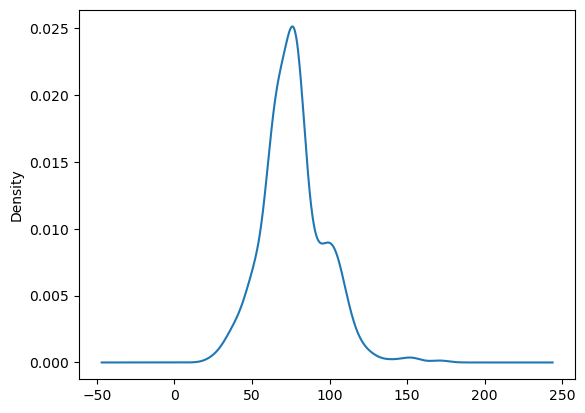

In [171]:
# plot distribution of delivery charges field
outlier_data['delivery_charges'].plot(kind='kde')

In [172]:
#Outlier Detection
q1 = outlier_data['delivery_charges'].quantile(0.25)
q3 = outlier_data['delivery_charges'].quantile(0.75)

IQR = q3 - q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

In [173]:
# Count outliers
outlier_count = len(outlier_data[(outlier_data['delivery_charges'] < lower_bound) | (outlier_data['delivery_charges'] > upper_bound)])

print(f'There are {outlier_count} rows with outlier delivery charges in a dataset containing {len(outlier_data)} rows.')

There are 18 rows with outlier delivery charges in a dataset containing 500 rows.


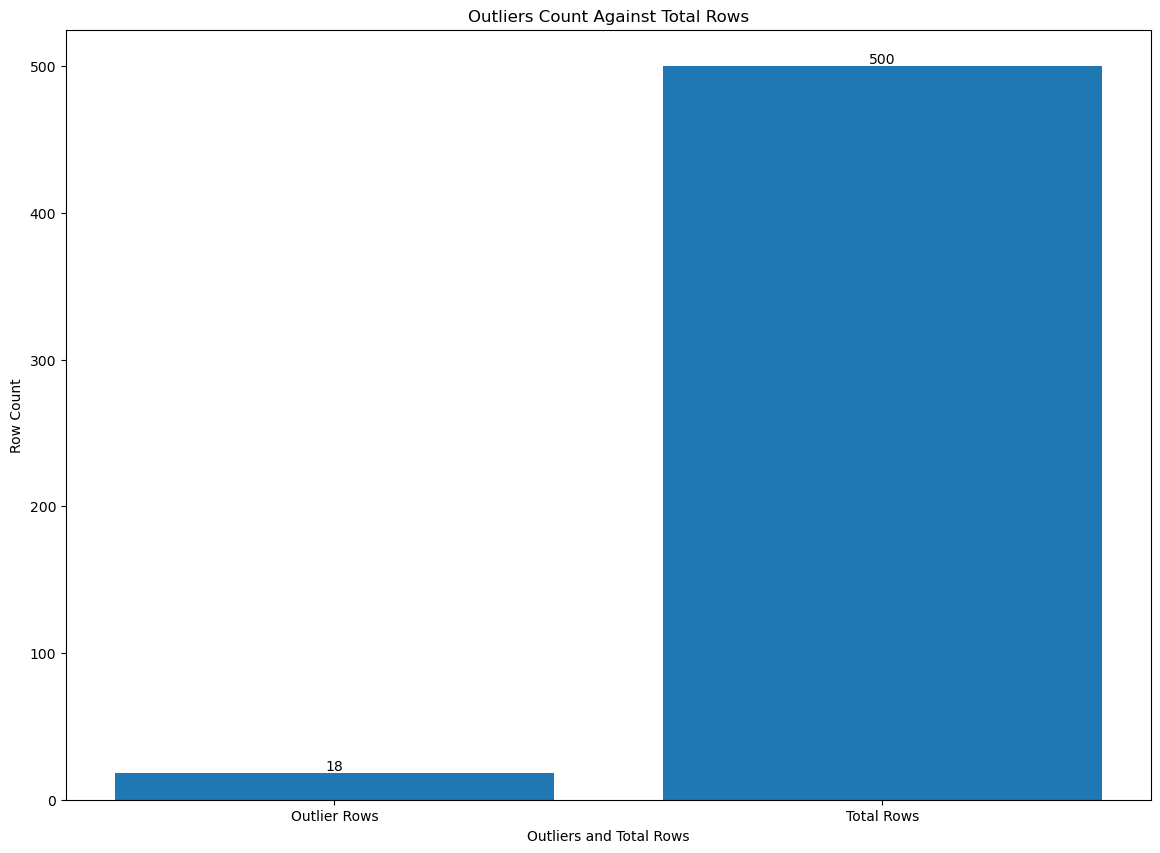

In [174]:
total_rows = len(outlier_data)

outlier_counts = [outlier_count, total_rows]
variables = ['Outlier Rows','Total Rows']

fig, ax = plt.subplots(figsize=(14, 10))
bars = plt.bar(variables, outlier_counts)

for bar in bars:
    height = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Outliers and Total Rows')
plt.ylabel('Row Count')
plt.title('Outliers Count Against Total Rows')
plt.show()

In [175]:
# Filter data frame on delivery charges values that are not outliers
outlier_data = outlier_data[~((outlier_data['delivery_charges'] < q1 - 1.5 * IQR) | (outlier_data['delivery_charges'] > q3 + 1.5 * IQR))]

In [176]:
# # Create outlier solution csv
outlier_data.to_csv('35087056_outlier_data_solution.csv')

## Delivery Charges Validation with Linear Regression - Missing Data Solution CSV

In [177]:
missing_data_clean = pd.read_csv('35087056_missing_data_solution.csv')

<Axes: ylabel='Density'>

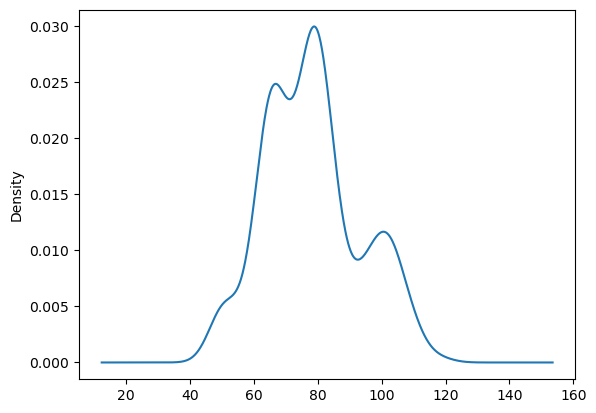

In [178]:
missing_data_clean['delivery_charges'].plot(kind='kde')

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

# Load the dataset
data = missing_data_clean

# Features and target
features = ["distance_to_nearest_warehouse", "is_expedited_delivery",
            "is_happy_customer", "order_total", "season"]

target = "delivery_charges"

# Outlier Detection
q1 = outlier_data['delivery_charges'].quantile(0.25)
q3 = outlier_data['delivery_charges'].quantile(0.75)

IQR = q3 - q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

# Filter outliers
filtered_data = data[(data["delivery_charges"] >= lower_bound) & (data["delivery_charges"] <= upper_bound)]

# Separate features and target
X_filtered = filtered_data[features]
y_filtered = filtered_data[target]

# Preprocessing: One-hot encode 'season', scale numerical features, and vectorize 'latest_customer_review'
preprocessor = ColumnTransformer(
    transformers=[
        ("season", OneHotEncoder(), ["season"]),
        ("scaler", StandardScaler(), ["distance_to_nearest_warehouse", "is_expedited_delivery", 
                                       "is_happy_customer", "order_total"])
    ]
)

# Build the pipeline
pipeline = make_pipeline(
    preprocessor,
    LinearRegression()
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.4, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Linear Regression R^2 Score: {round(r2,2)}")

Linear Regression R^2 Score: 0.95


## References